In [ ]:
cd ../..

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import re
import os
import seaborn as sns

In [2]:
def parse_time(time_str: str) -> pd.Timedelta:
    """Parses a time string in "X'Y"" (minutes'seconds") format to a pandas Timedelta."""
    match = re.match(r"(\d+)\'\s*(\d+)\"", time_str)
    if not match:
        raise ValueError(f"Invalid time format: {time_str}. Expected M'S\".")

    minutes, seconds = int(match.group(1)), int(match.group(2))
    return pd.Timedelta(minutes=minutes, seconds=seconds)


def split_value_and_error(df: pd.DataFrame, columns_to_split: list) -> pd.DataFrame:
    """
    Splits columns with 'value ± error' format into two new columns: '_M' (mean) and '_V' (variance/error).
    Original columns are dropped.
    """
    df_copy = df.copy()
    for col in columns_to_split:
        if col in df_copy.columns:
            df_copy[[f"{col}_M", f"{col}_V"]] = df_copy[col].str.extract(
                r"\s*([-\d\.eE]+)\s*±\s*([-\d\.eE]+)"
            )

            df_copy[f"{col}_M"] = pd.to_numeric(df_copy[f"{col}_M"], errors="coerce")
            df_copy[f"{col}_V"] = pd.to_numeric(df_copy[f"{col}_V"], errors="coerce")

            df_copy.drop(columns=[col], inplace=True)
        else:
            print(
                f"Warning: Column '{col}' not found in the DataFrame and will not be processed."
            )
    return df_copy


def custom_grouping(df: pd.DataFrame, group_cols: list) -> pd.DataFrame:
    """
    Groups the DataFrame by specified columns and summarizes the remaining columns.
    If a column has a single value within a group, that value is returned.
    If it has multiple values, a list of those values is returned.
    """
    def summarize_series(serie):
        unique_values = serie.unique()
        if len(unique_values) == 1:
            return unique_values[0]
        return serie.tolist()

    columns_to_aggregate = [col for col in df.columns if col not in group_cols]

    aggregation_dict = {col: summarize_series for col in columns_to_aggregate}

    result_df = df.groupby(group_cols, dropna=False).agg(aggregation_dict).reset_index()
    return result_df


def load_experiment_info(results_dir: Path) -> pd.DataFrame:
    """Loads experiment information from params.json files."""
    experiments_data = []
    if not results_dir.is_dir():
        print(
            f"Results directory '{results_dir}' does not exist. Creating an empty one."
        )
        results_dir.mkdir(parents=True, exist_ok=True)
        return pd.DataFrame()

    for entry in results_dir.iterdir():
        if entry.is_dir():
            params_file = entry / PARAMS_FILE_NAME
            if params_file.is_file():
                try:
                    with open(params_file, "rt") as f:
                        exp_data = json.load(f)
                        exp_data["hash"] = entry.name
                        experiments_data.append(exp_data)
                except json.JSONDecodeError:
                    print(f"Error: Could not parse JSON file: {params_file}")
                except Exception as e:
                    print(f"Unexpected error reading {params_file}: {e}")
    return pd.DataFrame(experiments_data)

In [ ]:
RESULTS_DIR = Path("results")
RESULTS_DIR = Path("old_results/experiment_1/")
EXCEL_FILE_NAME = "experiments.xlsx"
PARAMS_FILE_NAME = "params.json"

COLUMNS_TO_DROP = [
    "start",
    "algorithm",
    "timesteps",
    "total_time",
    "target_update_interval",
    "exploration_fraction",
    "exploration_initial_eps",
    "exploration_final_eps",
    "scaling",
    "buffer_size",
    "learning_starts",
    "train_freq",
    "train_freq_type",
    "experiment",
    "batch_size",
    "learning_rate",
    "dataset_path",
    "ones_mask",
]

COLUMNS_TO_SPLIT = [
    "reward",
    "step",
    "proba",
    "num_changes",
    "subsequences",
    "perc_changes",
    "L1",
    "L2",
    "improvement_nun",
]

In [4]:
exp_info = load_experiment_info(RESULTS_DIR)
print(f"Loaded experiments information from: {RESULTS_DIR}")

exp_info["weights_losses"] = exp_info["weights_losses"].astype(str)
exp_info["super_head"] = exp_info.get("super_head", pd.Series()).fillna("False")

try:
    df = pd.read_excel(RESULTS_DIR / EXCEL_FILE_NAME)
except FileNotFoundError:
    print(f"Error: The file '{EXCEL_FILE_NAME}' was not found in '{RESULTS_DIR}'.")
    exit()
except Exception as e:
    print(f"Error reading Excel file: {e}")

print(f"Loaded main data from: {RESULTS_DIR / EXCEL_FILE_NAME}")

Loaded experiments information from: results
Loaded main data from: results\experiments.xlsx


In [5]:
merge_cols = [
    "hash",
    "weights_losses",
    "algorithm",
    "mapping_mode",
    "timesteps",
    "ones_mask",
]
df = pd.merge(df, exp_info, on=merge_cols, how="inner", suffixes=("_x", "_y"))

# if "total_time" in df.columns:
#     try:
#         df["total_time"] = df["total_time"].apply(parse_time)
#     except ValueError as e:
#         print(f"Error parsing 'total_time' column: {e}")
df.head(5)

,hash,start,dataset,algorithm,super_head_x,ones_mask,weights_losses,mapping_mode,timesteps,total_time,...,train_freq,train_freq_type,learning_rate,target_update_interval,exploration_fraction,exploration_initial_eps,exploration_final_eps,super_head_y,gamma,dataset_path
0,01132d32372b,2025-06-19 21:41:45,chinatown,DQN,False,True,"[1, 1, 0, 0]",default,100000,"15' 8""",...,100,step,0.0001,2000,0.9,0.9,0.05,False,0.2,/UCR/chinatown
1,255a5ce9935d,2025-06-19 21:41:45,chinatown,DQN,False,True,"[1, 0, 1, 0]",default,100000,"14' 33""",...,100,step,0.0001,2000,0.9,0.9,0.05,False,0.0,/UCR/chinatown
2,9032d097cb0e,2025-06-19 21:41:45,chinatown,DQN,False,True,"[0, 1, 1, 0]",default,100000,"14' 24""",...,100,step,0.0001,2000,0.9,0.9,0.05,False,0.0,/UCR/chinatown
3,c151a4c4fbf3,2025-06-19 21:41:45,chinatown,DQN,False,True,"[1, 1, 1, 0]",default,100000,"14' 48""",...,100,step,0.0001,2000,0.9,0.9,0.05,False,0.0,/UCR/chinatown
4,01132d32372b,2025-06-19 21:41:45,chinatown,DQN,False,True,"[1, 1, 0, 0]",default,100000,"15' 8""",...,100,step,0.0001,2000,0.9,0.9,0.05,False,0.2,/UCR/chinatown


In [6]:
cols_to_drop_existing = [col for col in COLUMNS_TO_DROP if col in df.columns]
df.drop(columns=cols_to_drop_existing, inplace=True)

df = split_value_and_error(df, COLUMNS_TO_SPLIT)

for col_y in [col for col in df.columns if col.endswith("_y")]:
    original_col = col_y[:-2]
    if f"{original_col}_x" in df.columns:
        df.drop(columns=[col_y], inplace=True)
    else:
        df.rename(columns={col_y: original_col}, inplace=True)

if "super_head_x" in df.columns and "super_head_y" not in df.columns:
    df.rename(columns={"super_head_x": "super_head"}, inplace=True)
elif "super_head_y" in df.columns:
    df.drop(columns=["super_head_y"], inplace=True)
    df.rename(columns={"super_head_x": "super_head"}, inplace=True)

df.head(5)

,hash,dataset,super_head,weights_losses,mapping_mode,valid,gamma,reward_M,reward_V,step_M,...,subsequences_M,subsequences_V,perc_changes_M,perc_changes_V,L1_M,L1_V,L2_M,L2_V,improvement_nun_M,improvement_nun_V
0,01132d32372b,chinatown,False,"[1, 1, 0, 0]",default,1.00 ± 0.00,0.2,0.37,0.06,1.06,...,2.06,0.24,0.24,0.11,2.02,0.97,0.95,0.25,0.37,0.06
1,255a5ce9935d,chinatown,False,"[1, 0, 1, 0]",default,1.00 ± 0.00,0.0,0.23,0.00,0.18,...,1.00,0.00,0.99,0.02,5.68,1.16,1.52,0.33,0.00,0.00
2,9032d097cb0e,chinatown,False,"[0, 1, 1, 0]",default,1.00 ± 0.00,0.0,-0.51,0.03,1.08,...,2.03,0.17,0.38,0.04,2.49,0.61,1.03,0.23,0.26,0.03
3,c151a4c4fbf3,chinatown,False,"[1, 1, 1, 0]",default,1.00 ± 0.00,0.0,-0.01,0.03,6.09,...,2.96,0.47,0.29,0.09,2.35,0.74,1.04,0.25,0.17,0.03
4,01132d32372b,chinatown,False,"[1, 1, 0, 0]",default,1.00 ± 0.00,0.2,0.37,0.06,1.06,...,2.06,0.24,0.24,0.11,2.02,0.97,0.95,0.25,0.37,0.06


In [7]:
GROUPING_COLUMNS = ["weights_losses", "dataset", "mapping_mode"]#, "super_head"

summary_df = custom_grouping(df, GROUPING_COLUMNS)
# summary_df = summary_df[summary_df.dataset!="beef"]
summary_df

,weights_losses,dataset,mapping_mode,hash,super_head,valid,gamma,reward_M,reward_V,step_M,...,subsequences_M,subsequences_V,perc_changes_M,perc_changes_V,L1_M,L1_V,L2_M,L2_V,improvement_nun_M,improvement_nun_V
0,"[0, 1, 1, 0]",beef,default,"[837590141aaf, e0300546b9da, c1d6ef0bdbef, 5ea...","[False, False, False, False, True, True, True,...",1.00 ± 0.00,"[0.0, 0.0, 0.2, 0.5, 0.0, 0.2, 0.5, 0.7, 0.99,...","[-0.4, -0.41, -0.48, -0.43, -0.54, -0.59, -0.4...","[0.14, 0.13, 0.04, 0.1, 0.04, 0.02, 0.08, 0.07...","[3.07, 1.73, 1.87, 1.77, 0.8, 0.8, 2.37, 6.1, ...",...,"[1.73, 1.83, 1.93, 2.17, 1.8, 1.8, 1.93, 3.4, ...","[0.45, 0.38, 0.25, 0.46, 0.41, 0.41, 0.25, 0.7...","[0.5, 0.52, 0.66, 0.54, 0.79, 0.89, 0.5, 0.54,...","[0.27, 0.27, 0.09, 0.21, 0.11, 0.06, 0.18, 0.1...","[73.11, 72.81, 80.45, 71.66, 85.65, 89.69, 73....","[124.82, 126.26, 123.0, 118.26, 133.11, 133.51...","[5.98, 5.9, 6.31, 6.0, 6.3, 6.4, 5.94, 5.42, 6...","[10.11, 10.05, 9.75, 10.02, 10.03, 10.0, 10.12...","[0.23, 0.22, 0.15, 0.2, 0.09, 0.04, 0.23, 0.18...","[0.14, 0.13, 0.04, 0.1, 0.04, 0.02, 0.08, 0.07..."
1,"[0, 1, 1, 0]",beef,steps,"[a6b49169e589, ac8af4d74423, be7a26e4503b, c57...","[False, False, False, True, True, True, False,...",1.00 ± 0.00,"[0.0, 0.2, 0.5, 0.0, 0.2, 0.5, 0.7, 0.99, 0.7,...","[-0.6, -0.46, -0.5, -0.57, -0.47, -0.63, -0.63...","[0.0, 0.07, 0.08, 0.03, 0.06, 0.0, 0.0, 0.0, 0...","[1.0, 2.43, 2.53, 0.77, 1.73, 0.0, 0.0, 0.0, 0...",...,"[2.0, 2.3, 2.23, 1.77, 2.73, 1.0, 1.0, 1.0, 1....","[0.0, 1.02, 0.5, 0.43, 0.69, 0.0, 0.0, 0.0, 0....","[0.9, 0.61, 0.68, 0.85, 0.61, 1.0, 1.0, 1.0, 0...","[0.0, 0.16, 0.16, 0.09, 0.14, 0.0, 0.0, 0.0, 0...","[89.65, 81.19, 79.9, 86.95, 78.11, 95.44, 95.4...","[129.85, 128.45, 128.77, 135.46, 128.32, 132.7...","[6.45, 6.33, 6.12, 6.22, 6.2, 6.59, 6.59, 6.59...","[9.96, 9.97, 10.02, 10.06, 10.01, 9.94, 9.94, ...","[0.03, 0.17, 0.13, 0.06, 0.16, 0.0, 0.0, 0.0, ...","[0.0, 0.07, 0.08, 0.03, 0.06, 0.0, 0.0, 0.0, 0..."
2,"[0, 1, 1, 0]",beef,triangular,"[34e99e7c6642, 6f02ae3ee2e2, 0433722da377, 770...","[False, False, False, True, True, True, False,...",1.00 ± 0.00,"[0.0, 0.2, 0.5, 0.0, 0.2, 0.5, 0.7, 0.99, 0.7,...","[-0.41, -0.52, -0.53, -0.47, -0.48, -0.51, -0....","[0.12, 0.16, 0.05, 0.11, 0.09, 0.05, 0.09, 0.0...","[2.03, 1.0, 0.8, 1.6, 2.43, 0.83, 7.47, 0.77, ...",...,"[2.3, 1.33, 1.8, 2.33, 2.97, 1.83, 5.4, 1.77, ...","[0.75, 0.48, 0.41, 0.66, 1.99, 0.38, 2.34, 0.4...","[0.5, 0.76, 0.76, 0.63, 0.64, 0.73, 0.53, 0.89...","[0.26, 0.34, 0.12, 0.21, 0.21, 0.12, 0.25, 0.0...","[78.4, 85.95, 84.92, 71.68, 81.22, 82.75, 76.6...","[138.94, 136.83, 132.86, 114.15, 137.87, 130.7...","[6.02, 6.22, 6.29, 5.83, 6.16, 6.21, 5.87, 6.4...","[10.15, 10.08, 10.03, 9.49, 10.1, 10.06, 10.21...","[0.22, 0.11, 0.1, 0.15, 0.15, 0.11, 0.18, 0.04...","[0.12, 0.16, 0.05, 0.11, 0.09, 0.05, 0.09, 0.0..."
3,"[0, 1, 1, 0]",beef,value,"[9f20bb18bff1, 7e9417b49138, 421c403bbda8, acf...","[False, False, False, True, True, True, False,...",1.00 ± 0.00,"[0.0, 0.2, 0.5, 0.0, 0.2, 0.5, 0.7, 0.99, 0.7,...",-0.63,0.0,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",...,1.0,0.0,1.0,0.0,"[95.36, 95.44, 95.16, 95.44, 95.44, 95.44, 95....","[132.75, 132.77, 132.15, 132.77, 132.77, 132.7...","[6.59, 6.59, 6.58, 6.59, 6.59, 6.59, 6.58, 6.5...","[9.94, 9.94, 9.92, 9.94, 9.94, 9.94, 9.92, 9.9...",0.0,0.0
4,"[0, 1, 1, 0]",chinatown,default,"[9032d097cb0e, 07ff647aeeab, 4e80b6f66162, 804...","[False, False, False, True, True, True, False,...",1.00 ± 0.00,"[0.0, 0.2, 0.5, 0.0, 0.2, 0.5, 0.7, 0.99, 0.7,...","[-0.51, -0.73, -0.45, -0.44, -0.4, -0.58, -0.4...","[0.03, 0.0, 0.04, 0.08, 0.13, 0.0, 0.07, 0.0, ...","[1.08, 1.0, 1.1, 1.23, 0.89, 4.01, 1.12, 1.0, ...",...,"[2.03, 1.0, 2.05, 1.08, 1.0, 2.99, 1.1, 1.0, 1...","[0.17, 0.0, 0.22, 0.27, 0.0, 0.36, 0.44, 0.0, ...","[0.38, 0.92, 0.27, 0.33, 0.26, 0.46, 0.28, 0.9...","[0.04, 0.0, 0.07, 0.13, 0.26, 0.02, 0.13, 0.0,...","[2.49, 5.19, 1.99, 2.04, 2.14, 3.13, 1.93, 5.1...","[0.61, 1.03, 0.57, 1.3, 1.67, 0.71, 1

In [8]:
def mean(l):
    if not isinstance(l, list):
        l = [l]
    if len(l) == 1:
        return l[0]
    return sum(l) / len(l) if l else 0

# summary_df[(summary_df['weights_losses']==weights) & (summary_df.dataset=='chinatown')]
weights = '[1, 1, 1, 0]'
columm_to_show = "improvement_nun_M"
new_col = columm_to_show.split('_')[0]
xx = summary_df.copy()
xx[new_col] = xx[columm_to_show].apply(lambda x: mean(eval(str(x))))
xx[["weights_losses", "dataset", "mapping_mode", columm_to_show, new_col]][xx['weights_losses']==weights]

,weights_losses,dataset,mapping_mode,improvement_nun_M,improvement
48,"[1, 1, 1, 0]",beef,default,"[0.07, 0.07, 0.09, 0.13, 0.1, 0.1, 0.1, 0.06, ...",0.086364
49,"[1, 1, 1, 0]",beef,steps,"[0.06, 0.06, 0.09, 0.0, 0.02, 0.04, 0.08, 0.0,...",0.043000
50,"[1, 1, 1, 0]",beef,triangular,"[0.08, 0.11, 0.09, 0.05, 0.08, 0.1, 0.09, 0.01...",0.062000
51,"[1, 1, 1, 0]",beef,value,0.0,0.000000
52,"[1, 1, 1, 0]",chinatown,default,"[0.17, 0.12, 0.12, 0.22, 0.21, 0.19, 0.1, 0.04...",0.140000
53,"[1, 1, 1, 0]",chinatown,steps,"[0.12, 0.19, 0.19, 0.16, 0.16, 0.17, 0.18, 0.0...",0.137000
54,"[1, 1, 1, 0]",chinatown,triangular,"[0.15, 0.17, 0.13, 0.14, 0.04, 0.17, 0.16, 0.0...",0.116000
55,"[1, 1, 1, 0]",chinatown,value,"[0.04, 0.08, 0.01, 0.08, 0.04, 0.03, 0.01, 0.0...",0.039000
56,"[1, 1, 1, 0]",ecg200,default,"[0.07, 0.01, 0.14, 0.12, 0.12, 0.13, 0.12, 0.1...",0.104000
57,"[1, 1, 1, 0]",ecg200,steps,"[0.0, 0.07, 0.1, 0.05, 0.03, 0.09, 0.11, 0.0, ...",0.053000


In [9]:
def pooled_mean(values, dataset_len):
    if isinstance(values, str):
        values = eval(values)
    if not isinstance(values, list):
        values = [values]
    if len(values) == 0:
        return values[0]
    weighted_sum = np.sum(np.array(values) * np.array(dataset_len))
    pooled_mean = weighted_sum / np.sum([dataset_len] * len(values))   
    return pooled_mean

def pooled_variance(means, variances, dataset_len):
    if isinstance(means, str):
        means = eval(means)
    if isinstance(variances, str):
        variances = eval(variances)
    if not isinstance(means, list):
        means = [means]
    if not isinstance(variances, list):
        variances = [variances]

    if len(means) == 0 or len(variances) == 0:
        return np.nan

    n_i = dataset_len
    k = len(means)

    mu_pooled = np.sum(np.array(means) * n_i) / (n_i * k)
    sum_within = np.sum([(n_i - 1) * v for v in variances])
    sum_between = np.sum([n_i * (m - mu_pooled) ** 2 for m in means])
    numerator = sum_within + sum_between
    denominator = np.sum([(n_i - 1) for _ in means])

    pooled_var = numerator / denominator
    return pooled_var    

def calculate_pooled_mean(row, columns):
    for col in columns:
        if f"{col}_M" in row and f"{col}_V" in row:
            mean_col = row[f"{col}_M"]
            var_col = row[f"{col}_V"]
            dataset_len = 100 if row.dataset != "beef" else 30

            mean = pooled_mean(mean_col, dataset_len)
            var = pooled_variance(mean_col, var_col, dataset_len)

            row[col] = mean
            row[f"{col}_var"] = var
        else:
            row[col] = 0
            row[f"{col}_var"] = 0
    return row


metrics = ["proba", "subsequences", "perc_changes", "L2"]
summary = summary_df.apply(calculate_pooled_mean, args=(metrics,), axis=1)
summary

,weights_losses,dataset,mapping_mode,hash,super_head,valid,gamma,reward_M,reward_V,step_M,...,improvement_nun_M,improvement_nun_V,proba,proba_var,subsequences,subsequences_var,perc_changes,perc_changes_var,L2,L2_var
0,"[0, 1, 1, 0]",beef,default,"[837590141aaf, e0300546b9da, c1d6ef0bdbef, 5ea...","[False, False, False, False, True, True, True,...",1.00 ± 0.00,"[0.0, 0.0, 0.2, 0.5, 0.0, 0.2, 0.5, 0.7, 0.99,...","[-0.4, -0.41, -0.48, -0.43, -0.54, -0.59, -0.4...","[0.14, 0.13, 0.04, 0.1, 0.04, 0.02, 0.08, 0.07...","[3.07, 1.73, 1.87, 1.77, 0.8, 0.8, 2.37, 6.1, ...",...,"[0.23, 0.22, 0.15, 0.2, 0.09, 0.04, 0.23, 0.18...","[0.14, 0.13, 0.04, 0.1, 0.04, 0.02, 0.08, 0.07...",0.818182,0.134592,1.862727,0.705506,0.703636,0.164149,6.127273,9.852654
1,"[0, 1, 1, 0]",beef,steps,"[a6b49169e589, ac8af4d74423, be7a26e4503b, c57...","[False, False, False, True, True, True, False,...",1.00 ± 0.00,"[0.0, 0.2, 0.5, 0.0, 0.2, 0.5, 0.7, 0.99, 0.7,...","[-0.6, -0.46, -0.5, -0.57, -0.47, -0.63, -0.63...","[0.0, 0.07, 0.08, 0.03, 0.06, 0.0, 0.0, 0.0, 0...","[1.0, 2.43, 2.53, 0.77, 1.73, 0.0, 0.0, 0.0, 0...",...,"[0.03, 0.17, 0.13, 0.06, 0.16, 0.0, 0.0, 0.0, ...","[0.0, 0.07, 0.08, 0.03, 0.06, 0.0, 0.0, 0.0, 0...",0.863000,0.093167,1.690000,0.690510,0.856000,0.082811,6.424000,10.006356
2,"[0, 1, 1, 0]",beef,triangular,"[34e99e7c6642, 6f02ae3ee2e2, 0433722da377, 770...","[False, False, False, True, True, True, False,...",1.00 ± 0.00,"[0.0, 0.2, 0.5, 0.0, 0.2, 0.5, 0.7, 0.99, 0.7,...","[-0.41, -0.52, -0.53, -0.47, -0.48, -0.51, -0....","[0.12, 0.16, 0.05, 0.11, 0.09, 0.05, 0.09, 0.0...","[2.03, 1.0, 0.8, 1.6, 2.43, 0.83, 7.47, 0.77, ...",...,"[0.22, 0.11, 0.1, 0.15, 0.15, 0.11, 0.18, 0.04...","[0.12, 0.16, 0.05, 0.11, 0.09, 0.05, 0.09, 0.0...",0.807000,0.133794,2.460000,2.070214,0.685000,0.197433,6.160000,10.052793
3,"[0, 1, 1, 0]",beef,value,"[9f20bb18bff1, 7e9417b49138, 421c403bbda8, acf...","[False, False, False, True, True, True, False,...",1.00 ± 0.00,"[0.0, 0.2, 0.5, 0.0, 0.2, 0.5, 0.7, 0.99, 0.7,...",-0.63,0.0,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",...,0.0,0.0,0.910000,0.050000,1.000000,0.000000,1.000000,0.000000,6.588000,9.936017
4,"[0, 1, 1, 0]",chinatown,default,"[9032d097cb0e, 07ff647aeeab, 4e80b6f66162, 804...","[False, False, False, True, True, True, False,...",1.00 ± 0.00,"[0.0, 0.2, 0.5, 0.0, 0.2, 0.5, 0.7, 0.99, 0.7,...","[-0.51, -0.73, -0.45, -0.44, -0.4, -0.58, -0.4...","[0.03, 0.0, 0.04, 0.08, 0.13, 0.0, 0.07, 0.0, ...","[1.08, 1.0, 1.1, 1.23, 0.89, 4.01, 1.12, 1.0, ...",...,"[0.26, 0.04, 0.31, 0.33, 0.37, 0.19, 0.36, 0.0...","[0.03, 0.0, 0.04, 0.08, 0.13, 0.0, 0.07, 0.0, ...",0.970000,0.063323,1.522000,0.602996,0.476000,0.147327,1.117000,0.334607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,"[1, 1, 1, 0]",ecg200,value,"[9ac414957f31, 99b62f1ce8c8, 8971d1625644, e1e...","[False, False, False, True, True, True, False,...",1.00 ± 0.00,"[0.0, 0.2, 0.5, 0.0, 0.2, 0.5, 0.7, 0.99, 0.7,...","[-0.12, -0.12, -0.13, -0.12, -0.12, -0.13, -0....",0.0,"[1.0, 2.02, 0.98, 1.98, 1.98, 0.0, 1.0, 0.0, 0...",...,"[0.0, 0.01, 0.0, 0.01, 0.01, 0.0, 0.0, 0.0, 0....",0.0,0.990000,0.010000,1.000000,0.000000,0.991000,0.000070,5.687000,1.677839
60,"[1, 1, 1, 0]",gunpoint,default,"[f354599144ca, 7c757398b653, 0f5ef2e4f032, 7b4...","[False, False, False, True, True, True, False,...",1.00 ± 0.00,"[0.0, 0.2, 0.5, 0.0, 0.2, 0.5, 0.7, 0.99, 0.7,...","[-0.02, -0.01, -0.01, -0.0, -0.05, -0.08, -0.0...","[0.04, 0.04, 0.02, 0.02, 0.05, 0.02, 0.03, 0.0...","[3.39, 4.16, 3.34, 6.89, 2.0, 2.14, 2.53, 0.36...",...,"[0.09, 0.1, 0.11, 0.11, 0.06, 0.03, 0.09, 0.03...","[0.04, 0.04, 0.02, 0.02, 0.05, 0.02, 0.03, 0.0...",0.951000,0.063676,2.282000,1.665481,0.674000,0.153307,3.311000,1.958090
61,"[1, 1, 1, 0]",gunpoint,steps,"[efd1f9a15d7e, 2b1e25280c96, 4a3e49411beb, e78...","[False, False, False, True, True, True, False,...",1.00 ± 0.00,"[0.0, 0.2, 0.5, 0.0, 0.2, 0.5, 0.7, 0.99, 0.7,...","[-0.03, -0.05, -0.07, -0.05, -

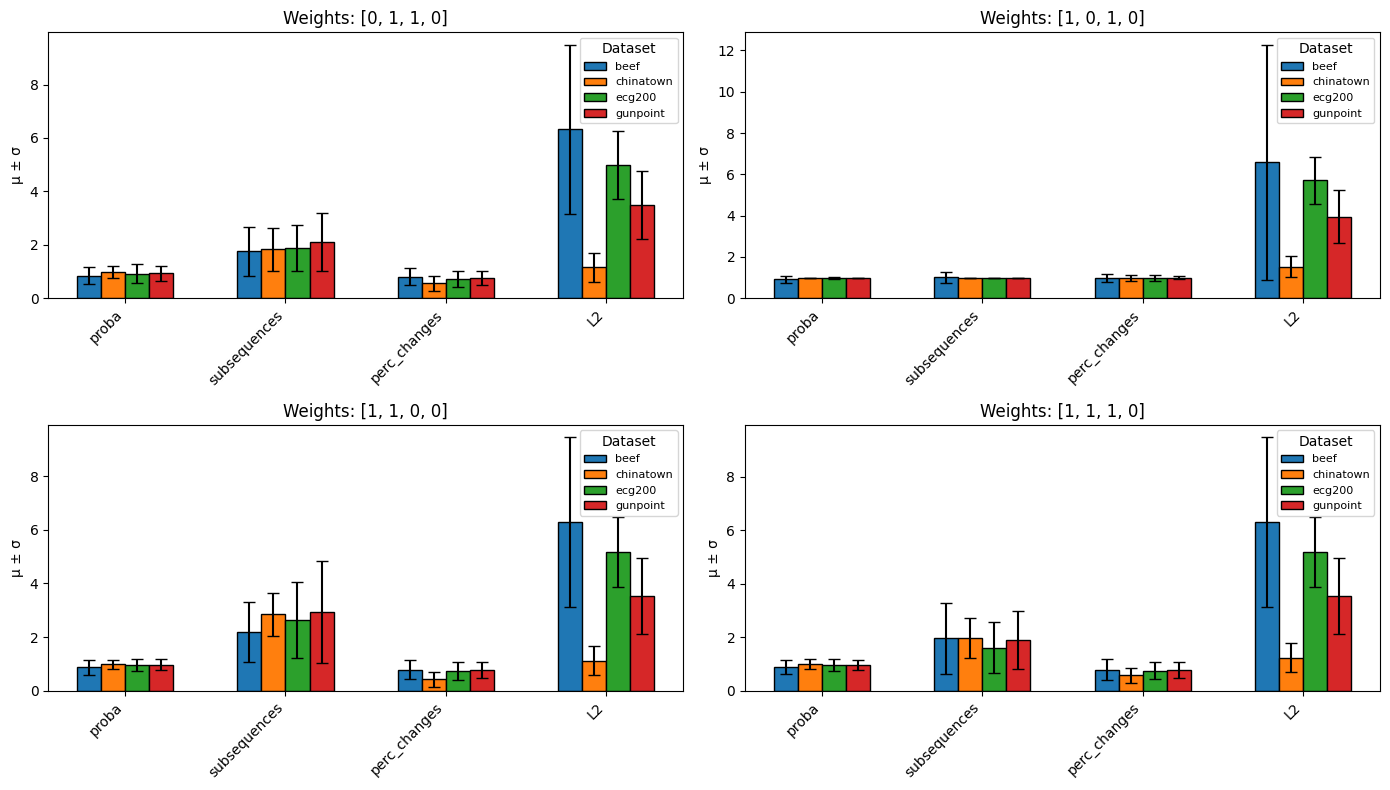

In [10]:
groups = summary['weights_losses'].unique()[:4]
datasets = summary['dataset'].unique()

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

bar_width = 0.15
x = np.arange(len(metrics))

colors = plt.cm.tab10.colors

for i, group in enumerate(groups):
    ax = axes[i]
    df_group = summary[summary['weights_losses'] == group]

    for j, dataset in enumerate(datasets):
        df_subset = df_group[df_group['dataset'] == dataset]
        if df_subset.empty:
            continue

        means = [df_subset[metric].mean() for metric in metrics]
        stds = [np.sqrt(df_subset[f"{metric}_var"].mean()) for metric in metrics]
        offset = (j - len(datasets)/2) * bar_width + bar_width / 2
        ax.bar(x + offset, means, yerr=stds, capsize=4, width=bar_width,
               label=dataset, color=colors[j % len(colors)], edgecolor="black")

    ax.set_xticks(x)
    ax.set_xticklabels(metrics, rotation=45, ha="right")
    ax.set_title(f"Weights: {group}")
    ax.set_ylabel("μ ± σ")
    ax.set_ylim(bottom=0)
    ax.legend(title="Dataset", fontsize=8)

plt.tight_layout()
plt.show()

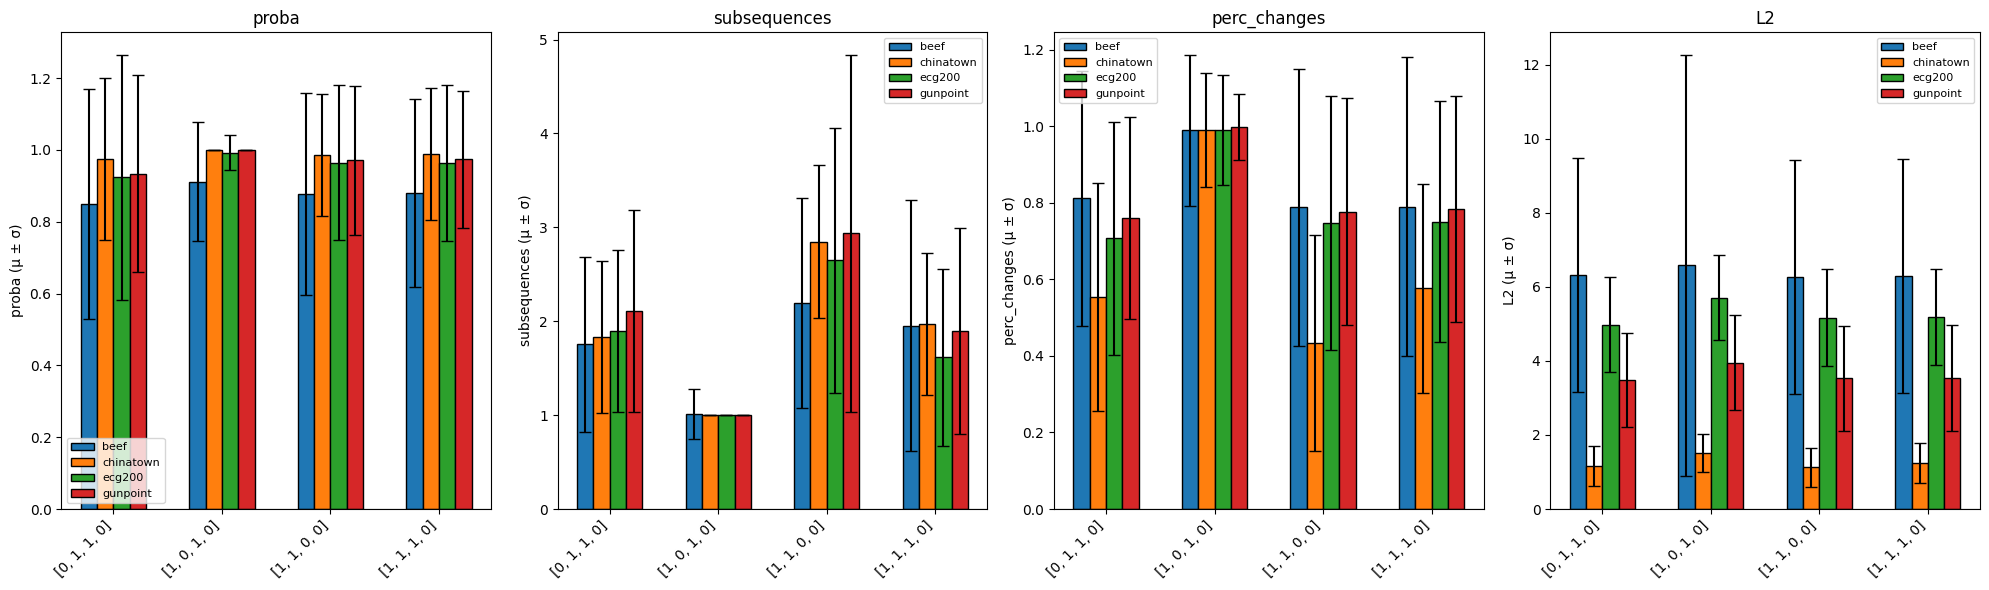

In [11]:
groups = summary['weights_losses'].unique()[:4]
datasets = summary['dataset'].unique()

fig, axes = plt.subplots(1, len(metrics), figsize=(5 * len(metrics), 6), sharey=False)

bar_width = 0.15
colors = plt.cm.tab10.colors
x = np.arange(len(groups))

for i, metric in enumerate(metrics):
    ax = axes[i]
    
    for j, dataset in enumerate(datasets):
        means = []
        stds = []
        for group in groups:
            df_subset = summary[(summary['weights_losses'] == group) & (summary['dataset'] == dataset)]
            if df_subset.empty:
                means.append(np.nan)
                stds.append(np.nan)
            else:
                means.append(df_subset[metric].mean())
                stds.append(np.sqrt(df_subset[f"{metric}_var"].mean()))
        
        offset = (j - len(datasets)/2) * bar_width + bar_width / 2
        ax.bar(x + offset, means, yerr=stds, capsize=4, width=bar_width,
               label=dataset, color=colors[j % len(colors)], edgecolor="black")

    ax.set_xticks(x)
    ax.set_xticklabels(groups, rotation=45, ha="right")
    ax.set_title(metric)
    ax.set_ylabel(f"{metric} (μ ± σ)")
    ax.axhline(0, color='black', linewidth=0.8)  # Para mostrar el 0 si hay negativos
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


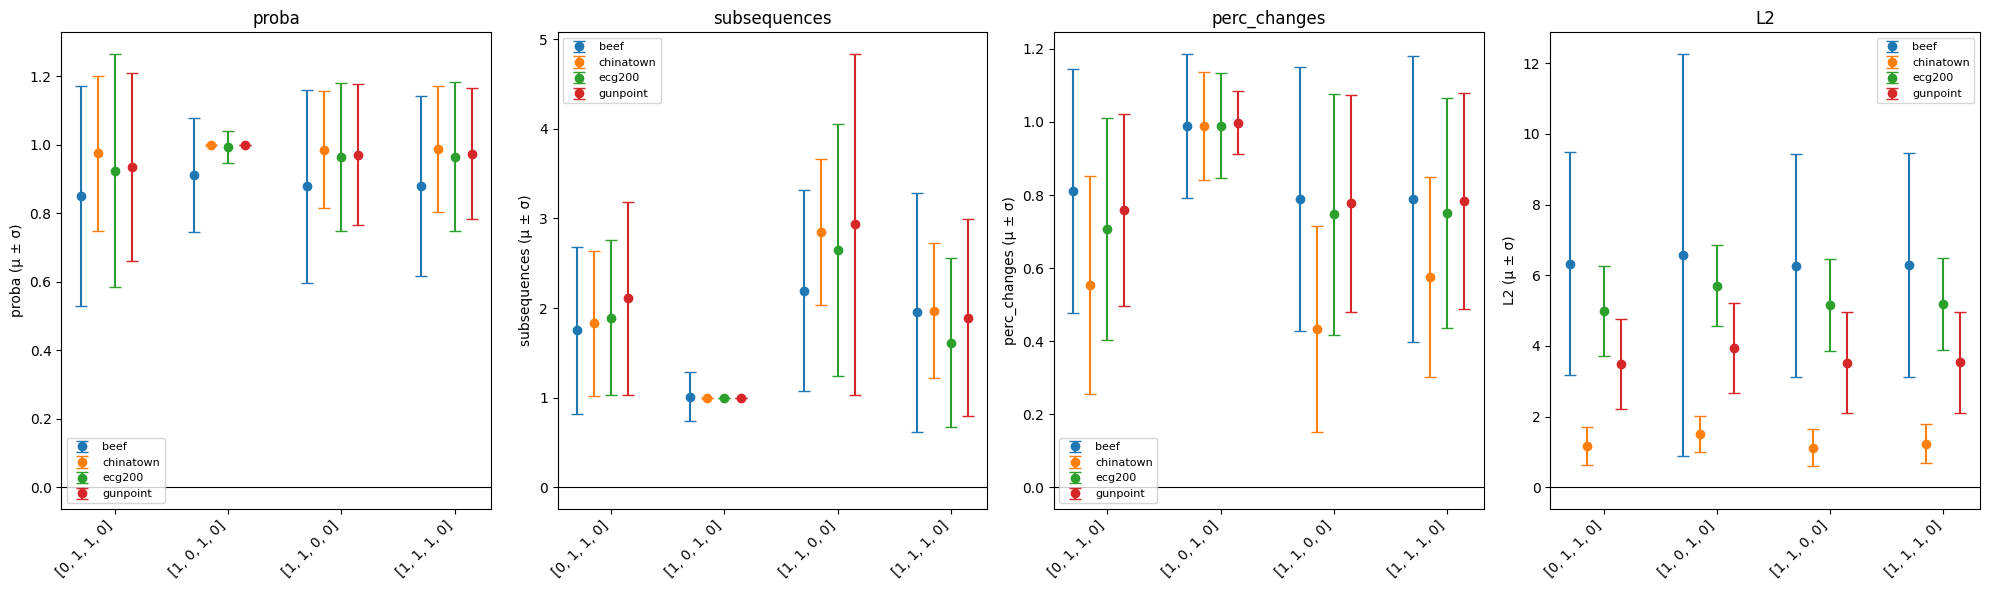

In [12]:
groups = summary['weights_losses'].unique()[:4]
datasets = summary['dataset'].unique()

fig, axes = plt.subplots(1, len(metrics), figsize=(5 * len(metrics), 6)) # Removed sharey=True

colors = plt.cm.tab10.colors

for i, metric in enumerate(metrics):
    ax = axes[i]
    for j, dataset in enumerate(datasets):
        y = []
        yerr = []
        labels = []
        for group in groups:
            df_subset = summary[(summary['weights_losses'] == group) & (summary['dataset'] == dataset)]
            if df_subset.empty:
                y.append(np.nan)
                yerr.append(np.nan)
            else:
                y.append(df_subset[metric].mean())
                yerr.append(np.sqrt(df_subset[f"{metric}_var"].mean()))
            labels.append(group)
        
        # Posiciones con desplazamiento vertical para evitar solapes
        x_pos = np.arange(len(groups)) + (j - len(datasets)/2) * 0.15
        ax.errorbar(x_pos, y, yerr=yerr, fmt='o', capsize=4,
                    label=dataset, color=colors[j % len(colors)], markersize=6)

    ax.set_xticks(np.arange(len(groups)))
    ax.set_xticklabels(groups, rotation=45, ha="right")
    ax.set_title(metric)
    ax.set_ylabel(f"{metric} (μ ± σ)") # The label now indicates it's specific to this axis
    ax.axhline(0, color='black', linewidth=0.8)
    ax.set_ylim(auto=True) # Ensure auto-scaling for each y-axis
    ax.legend(fontsize=8)

plt.tight_layout()

In [13]:
summary

,weights_losses,dataset,mapping_mode,hash,super_head,valid,gamma,reward_M,reward_V,step_M,...,improvement_nun_M,improvement_nun_V,proba,proba_var,subsequences,subsequences_var,perc_changes,perc_changes_var,L2,L2_var
0,"[0, 1, 1, 0]",beef,default,"[837590141aaf, e0300546b9da, c1d6ef0bdbef, 5ea...","[False, False, False, False, True, True, True,...",1.00 ± 0.00,"[0.0, 0.0, 0.2, 0.5, 0.0, 0.2, 0.5, 0.7, 0.99,...","[-0.4, -0.41, -0.48, -0.43, -0.54, -0.59, -0.4...","[0.14, 0.13, 0.04, 0.1, 0.04, 0.02, 0.08, 0.07...","[3.07, 1.73, 1.87, 1.77, 0.8, 0.8, 2.37, 6.1, ...",...,"[0.23, 0.22, 0.15, 0.2, 0.09, 0.04, 0.23, 0.18...","[0.14, 0.13, 0.04, 0.1, 0.04, 0.02, 0.08, 0.07...",0.818182,0.134592,1.862727,0.705506,0.703636,0.164149,6.127273,9.852654
1,"[0, 1, 1, 0]",beef,steps,"[a6b49169e589, ac8af4d74423, be7a26e4503b, c57...","[False, False, False, True, True, True, False,...",1.00 ± 0.00,"[0.0, 0.2, 0.5, 0.0, 0.2, 0.5, 0.7, 0.99, 0.7,...","[-0.6, -0.46, -0.5, -0.57, -0.47, -0.63, -0.63...","[0.0, 0.07, 0.08, 0.03, 0.06, 0.0, 0.0, 0.0, 0...","[1.0, 2.43, 2.53, 0.77, 1.73, 0.0, 0.0, 0.0, 0...",...,"[0.03, 0.17, 0.13, 0.06, 0.16, 0.0, 0.0, 0.0, ...","[0.0, 0.07, 0.08, 0.03, 0.06, 0.0, 0.0, 0.0, 0...",0.863000,0.093167,1.690000,0.690510,0.856000,0.082811,6.424000,10.006356
2,"[0, 1, 1, 0]",beef,triangular,"[34e99e7c6642, 6f02ae3ee2e2, 0433722da377, 770...","[False, False, False, True, True, True, False,...",1.00 ± 0.00,"[0.0, 0.2, 0.5, 0.0, 0.2, 0.5, 0.7, 0.99, 0.7,...","[-0.41, -0.52, -0.53, -0.47, -0.48, -0.51, -0....","[0.12, 0.16, 0.05, 0.11, 0.09, 0.05, 0.09, 0.0...","[2.03, 1.0, 0.8, 1.6, 2.43, 0.83, 7.47, 0.77, ...",...,"[0.22, 0.11, 0.1, 0.15, 0.15, 0.11, 0.18, 0.04...","[0.12, 0.16, 0.05, 0.11, 0.09, 0.05, 0.09, 0.0...",0.807000,0.133794,2.460000,2.070214,0.685000,0.197433,6.160000,10.052793
3,"[0, 1, 1, 0]",beef,value,"[9f20bb18bff1, 7e9417b49138, 421c403bbda8, acf...","[False, False, False, True, True, True, False,...",1.00 ± 0.00,"[0.0, 0.2, 0.5, 0.0, 0.2, 0.5, 0.7, 0.99, 0.7,...",-0.63,0.0,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",...,0.0,0.0,0.910000,0.050000,1.000000,0.000000,1.000000,0.000000,6.588000,9.936017
4,"[0, 1, 1, 0]",chinatown,default,"[9032d097cb0e, 07ff647aeeab, 4e80b6f66162, 804...","[False, False, False, True, True, True, False,...",1.00 ± 0.00,"[0.0, 0.2, 0.5, 0.0, 0.2, 0.5, 0.7, 0.99, 0.7,...","[-0.51, -0.73, -0.45, -0.44, -0.4, -0.58, -0.4...","[0.03, 0.0, 0.04, 0.08, 0.13, 0.0, 0.07, 0.0, ...","[1.08, 1.0, 1.1, 1.23, 0.89, 4.01, 1.12, 1.0, ...",...,"[0.26, 0.04, 0.31, 0.33, 0.37, 0.19, 0.36, 0.0...","[0.03, 0.0, 0.04, 0.08, 0.13, 0.0, 0.07, 0.0, ...",0.970000,0.063323,1.522000,0.602996,0.476000,0.147327,1.117000,0.334607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,"[1, 1, 1, 0]",ecg200,value,"[9ac414957f31, 99b62f1ce8c8, 8971d1625644, e1e...","[False, False, False, True, True, True, False,...",1.00 ± 0.00,"[0.0, 0.2, 0.5, 0.0, 0.2, 0.5, 0.7, 0.99, 0.7,...","[-0.12, -0.12, -0.13, -0.12, -0.12, -0.13, -0....",0.0,"[1.0, 2.02, 0.98, 1.98, 1.98, 0.0, 1.0, 0.0, 0...",...,"[0.0, 0.01, 0.0, 0.01, 0.01, 0.0, 0.0, 0.0, 0....",0.0,0.990000,0.010000,1.000000,0.000000,0.991000,0.000070,5.687000,1.677839
60,"[1, 1, 1, 0]",gunpoint,default,"[f354599144ca, 7c757398b653, 0f5ef2e4f032, 7b4...","[False, False, False, True, True, True, False,...",1.00 ± 0.00,"[0.0, 0.2, 0.5, 0.0, 0.2, 0.5, 0.7, 0.99, 0.7,...","[-0.02, -0.01, -0.01, -0.0, -0.05, -0.08, -0.0...","[0.04, 0.04, 0.02, 0.02, 0.05, 0.02, 0.03, 0.0...","[3.39, 4.16, 3.34, 6.89, 2.0, 2.14, 2.53, 0.36...",...,"[0.09, 0.1, 0.11, 0.11, 0.06, 0.03, 0.09, 0.03...","[0.04, 0.04, 0.02, 0.02, 0.05, 0.02, 0.03, 0.0...",0.951000,0.063676,2.282000,1.665481,0.674000,0.153307,3.311000,1.958090
61,"[1, 1, 1, 0]",gunpoint,steps,"[efd1f9a15d7e, 2b1e25280c96, 4a3e49411beb, e78...","[False, False, False, True, True, True, False,...",1.00 ± 0.00,"[0.0, 0.2, 0.5, 0.0, 0.2, 0.5, 0.7, 0.99, 0.7,...","[-0.03, -0.05, -0.07, -0.05, -

In [14]:
import math


def extract_mean(series):
    return (
        series.astype(str)
        .str.split("±")
        .str[0]
        .str.strip()
        .str.replace(",", ".")
        .astype(float)
    )


summary["proba_mean"] = extract_mean(summary["proba"])
summary["subsequences_mean"] = extract_mean(summary["subsequences"])
summary["perc_changes_mean"] = extract_mean(summary["perc_changes"])
summary["L2_mean"] = extract_mean(summary["L2"])


# Infer gamma
def assign_gamma(df):
    n = len(df)
    if df.name == "beef":
        first4 = [0] * 4
        rest_needed = n - 4
        rest = ([0, 0.2, 0.5] * math.ceil(rest_needed / 3))[:rest_needed]
        gamma = first4 + rest
        return pd.Series(gamma, index=df.index)
    else:
        seq = [0, 0.2, 0.5]
        gamma = (seq * math.ceil(n / 3))[:n]
        return pd.Series(gamma, index=df.index)


summary["gamma"] = summary.groupby("dataset", group_keys=False).apply(assign_gamma)

# Best per dataset and weights based on minimal L2_mean
best_per_group = summary.loc[
    summary.groupby(["dataset", "weights_losses"])["L2_mean"].idxmin()
].reset_index(drop=True)
best_1110 = best_per_group[best_per_group["weights_losses"] == "[1, 1, 1, 0]"]
best_1110

C:\Users\Yago\AppData\Local\Temp\ipykernel_19240\2922846388.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary["gamma"] = summary.groupby("dataset", group_keys=False).apply(assign_gamma)


,weights_losses,dataset,mapping_mode,hash,super_head,valid,gamma,reward_M,reward_V,step_M,...,subsequences,subsequences_var,perc_changes,perc_changes_var,L2,L2_var,proba_mean,subsequences_mean,perc_changes_mean,L2_mean
3,"[1, 1, 1, 0]",beef,default,"[542cf5bfe383, e319478ef9ce, af3964c9b833, 631...","[False, False, False, False, True, True, True,...",1.00 ± 0.00,0.5,"[-0.04, -0.04, -0.03, 0.02, -0.01, -0.01, -0.0...","[0.06, 0.06, 0.06, 0.09, 0.08, 0.08, 0.08, 0.0...","[1.93, 2.3, 6.0, 2.1, 3.5, 1.23, 6.93, 3.5, 0....",...,2.044545,1.332665,0.637273,0.225469,6.050,9.907549,0.850,2.044545,0.637273,6.050
7,"[1, 1, 1, 0]",chinatown,default,"[c151a4c4fbf3, ca0456c70a89, 874f5f310796, e86...","[False, False, False, True, True, True, False,...",1.00 ± 0.00,0.0,"[-0.01, -0.06, -0.06, 0.04, 0.04, 0.01, -0.07,...","[0.03, 0.0, 0.01, 0.03, 0.03, 0.03, 0.02, 0.0,...","[6.09, 1.02, 6.58, 1.43, 1.13, 1.29, 5.35, 1.0...",...,2.445000,0.993621,0.438000,0.088461,1.136,0.280610,0.982,2.445000,0.438000,1.136
11,"[1, 1, 1, 0]",ecg200,default,"[13a317f291dc, 037b65100768, 465eb184ac5b, e69...","[False, False, False, True, True, True, False,...",1.00 ± 0.00,0.0,"[-0.06, -0.12, 0.01, -0.01, -0.01, 0.0, -0.01,...","[0.02, 0.0, 0.06, 0.04, 0.07, 0.06, 0.1, 0.07,...","[0.96, 1.0, 1.7, 1.39, 1.26, 6.04, 0.96, 0.81,...",...,1.615000,1.493197,0.599000,0.175595,4.867,1.735233,0.937,1.615000,0.599000,4.867
15,"[1, 1, 1, 0]",gunpoint,default,"[f354599144ca, 7c757398b653, 0f5ef2e4f032, 7b4...","[False, False, False, True, True, True, False,...",1.00 ± 0.00,0.0,"[-0.02, -0.01, -0.01, -0.0, -0.05, -0.08, -0.0...","[0.04, 0.04, 0.02, 0.02, 0.05, 0.02, 0.03, 0.0...","[3.39, 4.16, 3.34, 6.89, 2.0, 2.14, 2.53, 0.36...",...,2.282000,1.665481,0.674000,0.153307,3.311,1.958090,0.951,2.282000,0.674000,3.311


In [15]:
df_list = []

for subdir in RESULTS_DIR.iterdir():
    if subdir.is_dir():
        json_path = os.path.join(subdir, "params.json")
        with open(json_path, "r") as f:
            params = json.load(f)
        excel_path = os.path.join(subdir, "cfes_info.xlsx")
        df = pd.read_excel(excel_path)
        df["dataset"] = params.get("dataset_path", "unknown").split("/")[-1]
        df["mapping_mode"] = params.get("mapping_mode")
        df["super_head"] = params.get("super_head", "False")
        df["gamma"] = params.get("gamma", "0")
        df["weights_losses"] = str(params.get("weights_losses", []))
        new_index = [f"{subdir.name}_{i}" for i in df.index]
        df.index = new_index
        df_list.append(df)

combined_df = pd.concat(df_list)
combined_df["super_head"].fillna(False, inplace=True)
combined_df = combined_df.drop(columns=["sample", "nun", "step"], errors="ignore")

# Normalize L1 by timesteps
timesteps = {"chinatown": 24, "ecg200": 96, "gunpoint": 150, "beef": 470}
combined_df["L1_normalized"] = combined_df.apply(lambda row: row["L1"] / timesteps[row["dataset"]], axis=1)

combined_df

C:\Users\Yago\AppData\Local\Temp\ipykernel_19240\449096813.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_df["super_head"].fillna(False, inplace=True)
C:\Users\Yago\AppData\Local\Temp\ipykernel_19240\449096813.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined_df["super_head"].fillna(F

,mask,reward,proba,subsequences,num_changes,perc_changes,L1,L2,improvement_nun,valid,dataset,mapping_mode,super_head,gamma,weights_losses,L1_normalized
00e9a8c884d5_0,[[ True True True True True True True T...,-0.011960,0.976080,1,96,1.000000,44.788025,6.081995,0.000000,True,ecg200,triangular,False,0.7,"[1, 1, 0, 0]",0.466542
00e9a8c884d5_1,[[ True True True True True True True T...,-0.001815,0.996371,1,96,1.000000,42.638371,6.071669,0.000000,True,ecg200,triangular,False,0.7,"[1, 1, 0, 0]",0.444150
00e9a8c884d5_2,[[ True True True True True True False Fa...,0.303379,0.877590,2,26,0.270833,9.252798,2.614532,0.303699,True,ecg200,triangular,False,0.7,"[1, 1, 0, 0]",0.096383
00e9a8c884d5_3,[[ True True True True True True True T...,-0.001815,0.996371,1,96,1.000000,41.059387,5.471074,0.000000,True,ecg200,triangular,False,0.7,"[1, 1, 0, 0]",0.427702
00e9a8c884d5_4,[[ True True True True True True False Fa...,0.334254,0.939341,2,26,0.270833,20.849699,4.840325,0.336714,True,ecg200,triangular,False,0.7,"[1, 1, 0, 0]",0.217184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffc7671657eb_95,[[ True True True True True True True T...,-0.501942,0.852321,2,53,0.552083,23.966494,3.976451,0.188017,True,ecg200,default,False,0.7,"[0, 1, 1, 0]",0.249651
ffc7671657eb_96,[[ True True True False False False False Fa...,-0.484375,0.943573,3,45,0.468750,22.526699,4.398324,0.205584,True,ecg200,default,False,0.7,"[0, 1, 1, 0]",0.234653
ffc7671657eb_97,[[ True True True True True True True T...,-0.501942,0.521538,2,53,0.552083,26.175940,4.846148,0.188017,True,ecg200,default,False,0.7,"[0, 1, 1, 0]",0.272666
ffc7671657eb_98,[[ True True True False False False False Fa...,-0.484375,0.833411,3,45,0.468750,23.630289,5.307197,0.205584,True,ecg200,default,False,0.7,"[0, 1, 1, 0]",0.246149


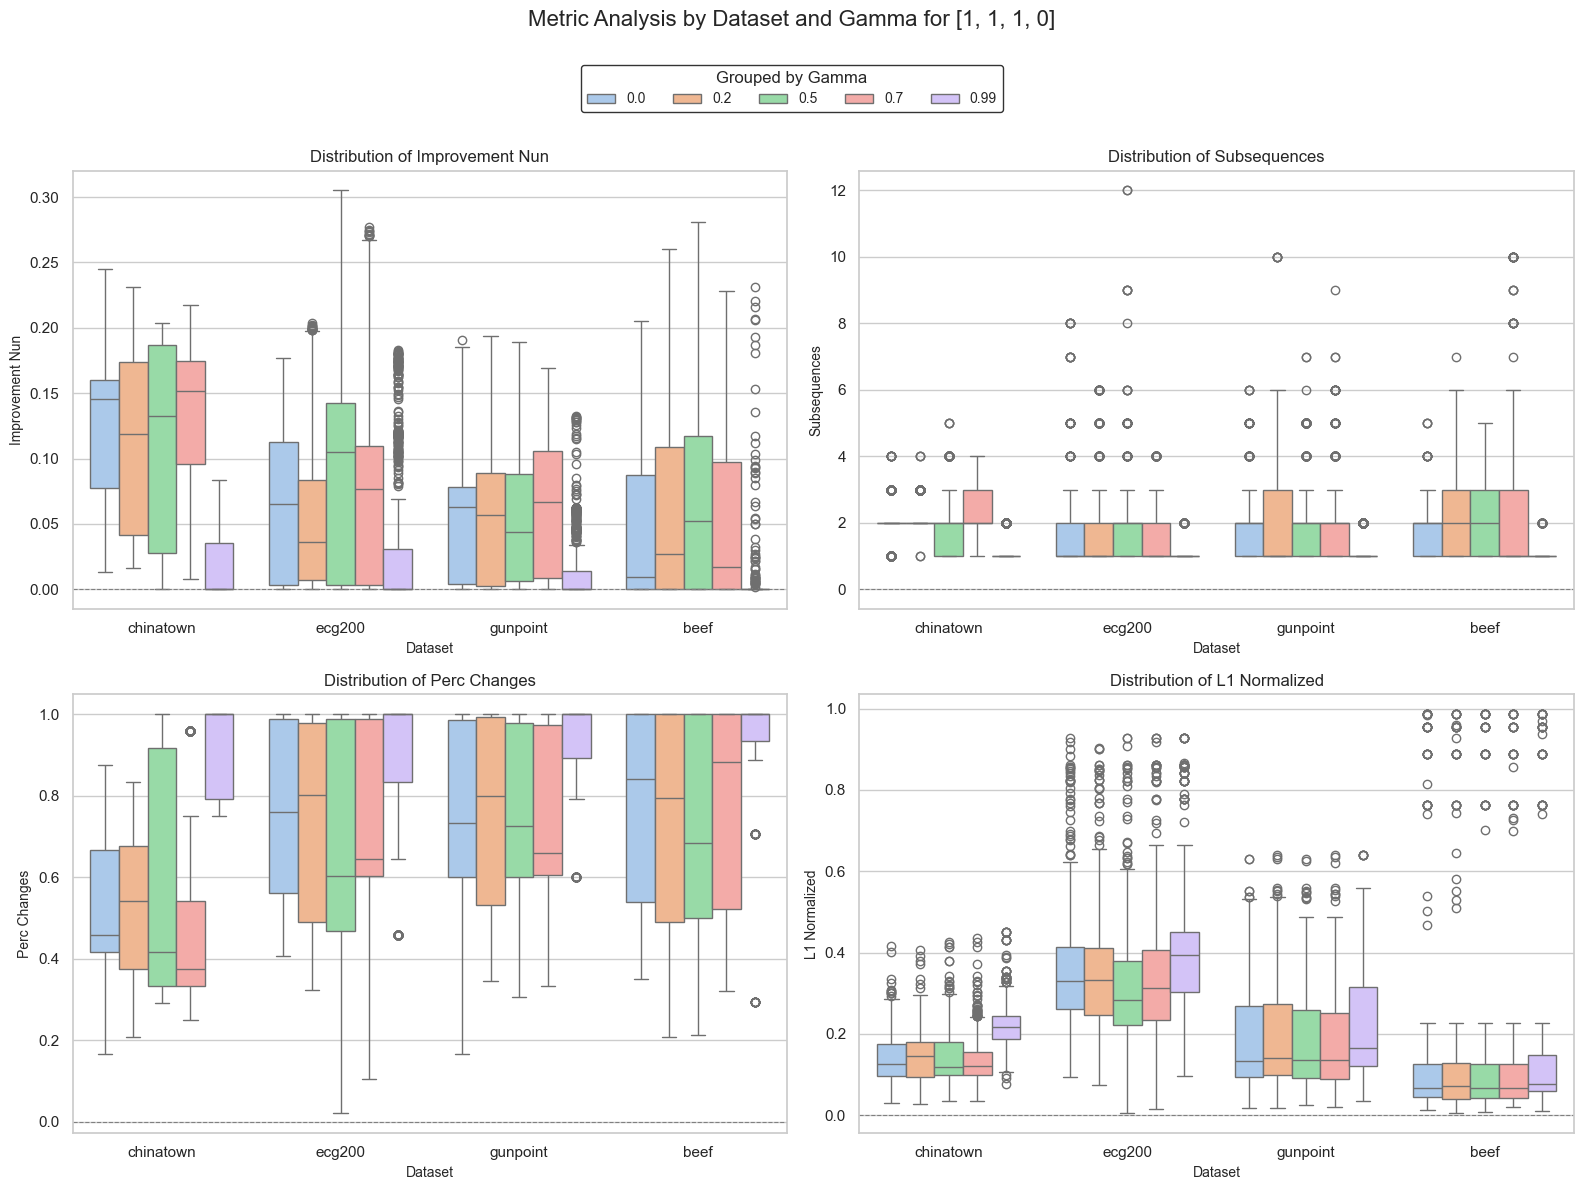

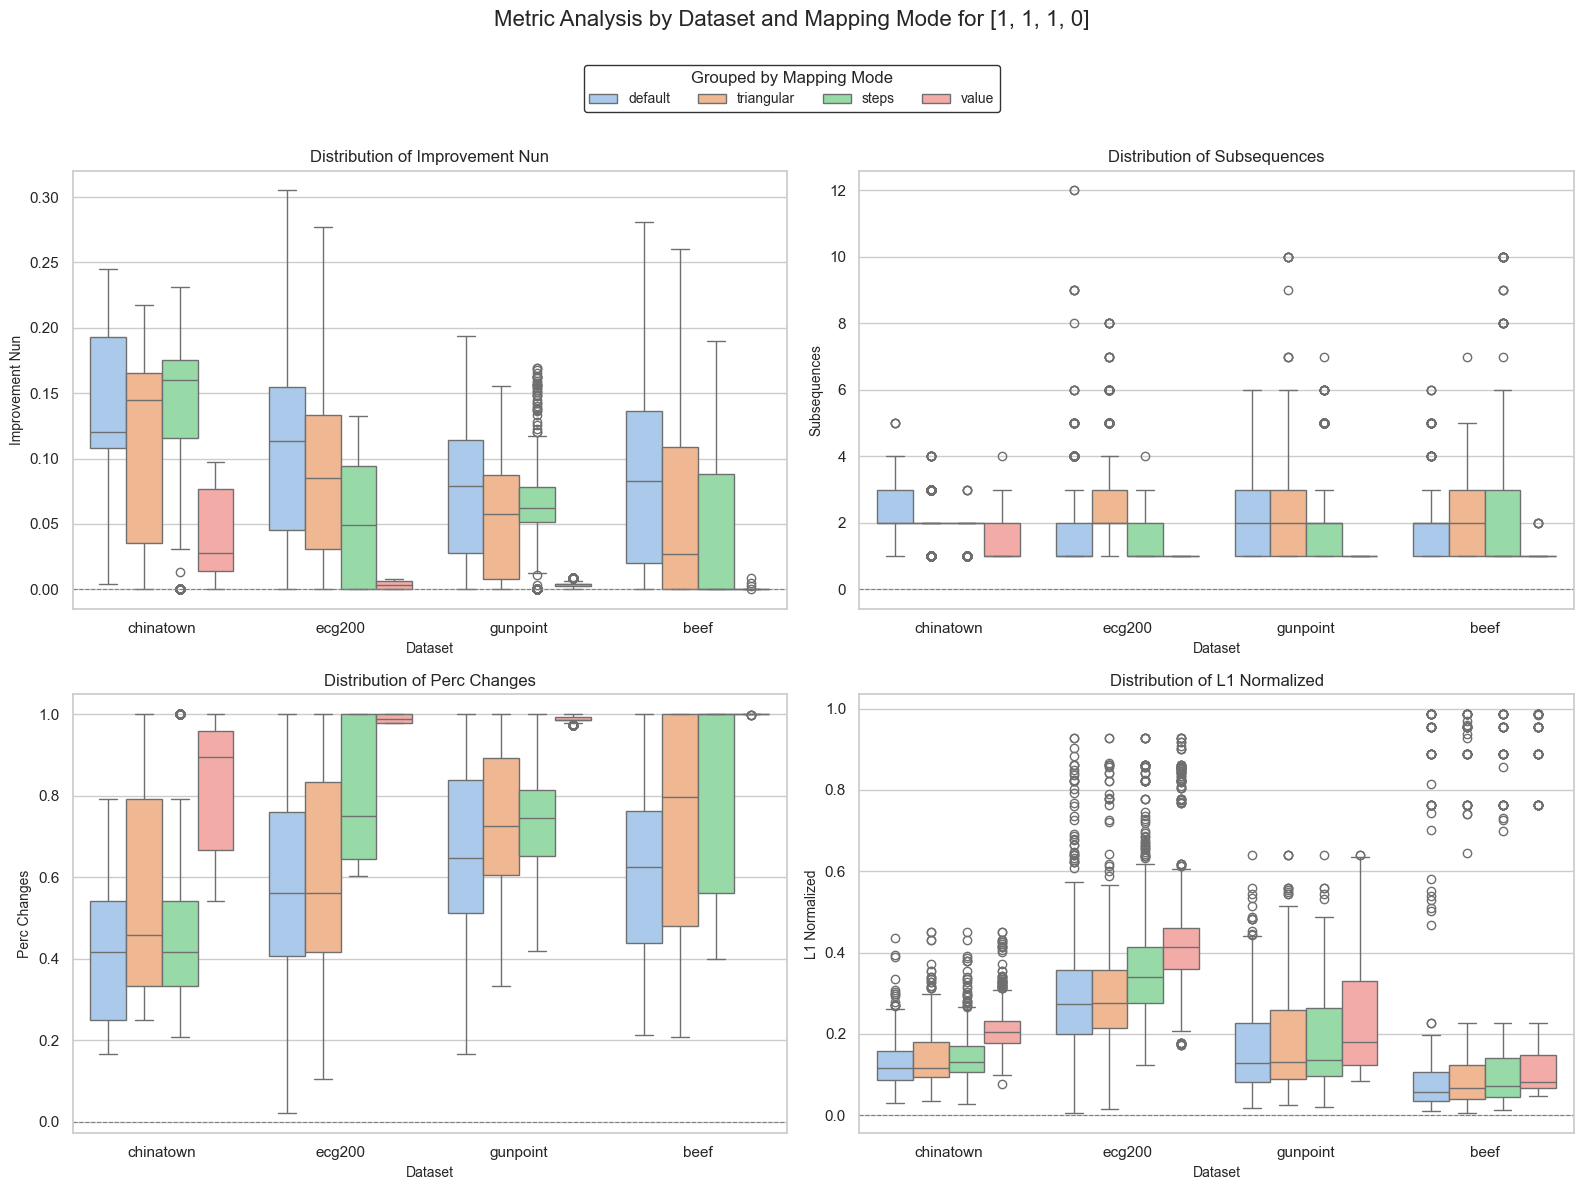

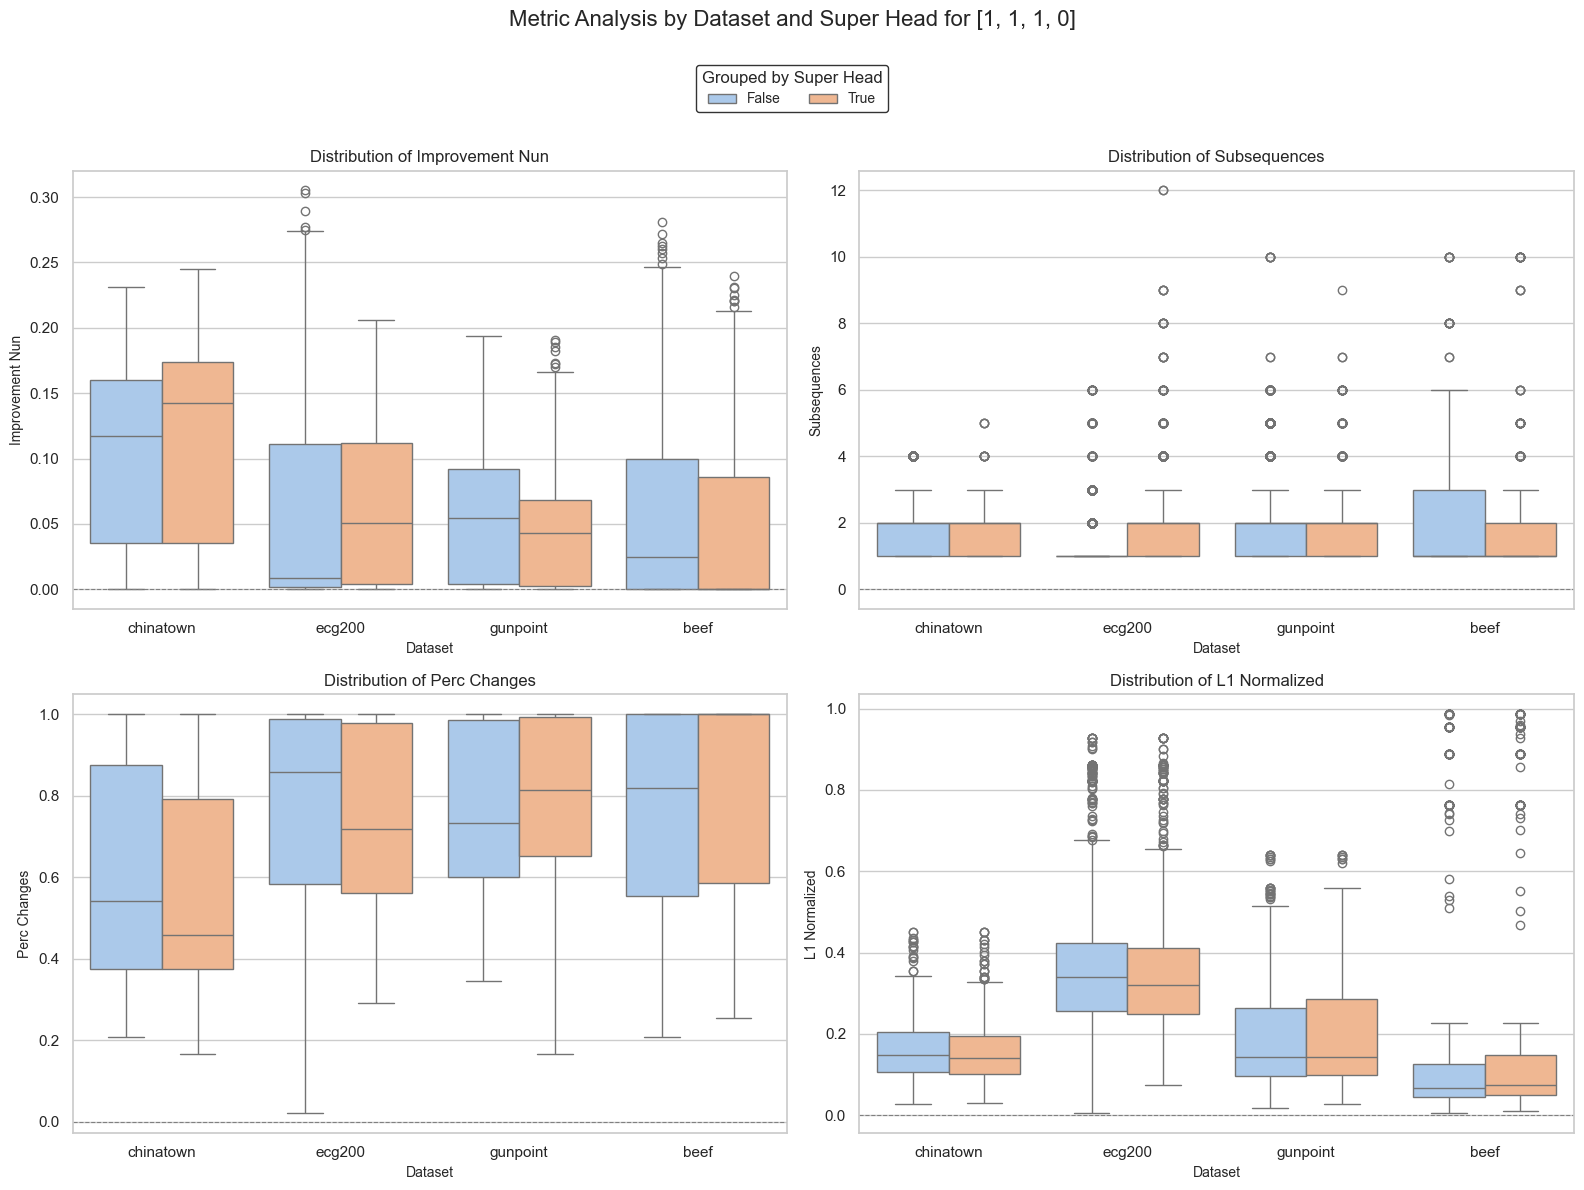

In [16]:
weights = "[1, 1, 1, 0]"
metrics = ["improvement_nun", "subsequences", "perc_changes", "L1_normalized"]
combined_1110 = combined_df[combined_df["weights_losses"] == weights]

sns.set_theme(style="whitegrid")

dataset_order = ["chinatown", "ecg200", "gunpoint", "beef"]

for comb in ["gamma", "mapping_mode", "super_head"]:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    handles, labels = None, None

    if comb == "mapping_mode":
        hue_order = ["default", "triangular", "steps", "value"]
    elif comb == "super_head":
        hue_order = [False, True]
    else:
        hue_order = sorted(combined_1110[comb].unique())

    for idx, metric in enumerate(metrics):
        ax = axes[idx]

        sns_plot = sns.boxplot(
            data=combined_1110,
            x="dataset",
            y=metric,
            hue=comb,
            palette="pastel",
            ax=ax,
            order=dataset_order,
            hue_order=hue_order
        )

        ax.set_title(f"Distribution of {metric.replace('_', ' ').title()}", fontsize=12)
        ax.set_xlabel("Dataset", fontsize=10)
        ax.set_ylabel(metric.replace('_', ' ').title(), fontsize=10)
        ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)

        if handles is None or labels is None:
            handles, labels = ax.get_legend_handles_labels()
        ax.legend_.remove()

    fig.legend(
        handles,
        labels,
        title=f"Grouped by {comb.replace('_', ' ').title()}",
        loc='upper center',
        bbox_to_anchor=(0.5, 0.98),
        ncol=len(labels),
        fontsize=10,
        frameon=True,
        edgecolor='black'
    )

    fig.suptitle(f"Metric Analysis by Dataset and {comb.replace('_', ' ').title()} for {weights}", fontsize=16, y=1.02)
    fig.tight_layout(rect=[0.0, 0.03, 1, 0.95])
    plt.show()

In [17]:
grouped = (
    combined_1110.groupby(['weights_losses', 'dataset', 'mapping_mode'])[metrics]
    .agg(['mean', 'std'])
    .round(4)
)

# Rename columns: `variable_mean`` and `variable_var`
grouped.columns = [f'{metric}_{stat}' for metric, stat in grouped.columns]
grouped = grouped.reset_index()
grouped

,weights_losses,dataset,mapping_mode,improvement_nun_mean,improvement_nun_std,subsequences_mean,subsequences_std,perc_changes_mean,perc_changes_std,L1_normalized_mean,L1_normalized_std
0,"[1, 1, 1, 0]",beef,default,0.0866,0.0693,2.0455,1.1276,0.6364,0.2406,0.1665,0.2722
1,"[1, 1, 1, 0]",beef,steps,0.0433,0.0548,2.4000,2.4427,0.8021,0.2310,0.1853,0.2801
2,"[1, 1, 1, 0]",beef,triangular,0.0627,0.0727,2.3467,1.2879,0.7172,0.2739,0.1802,0.2850
3,"[1, 1, 1, 0]",beef,value,0.0001,0.0006,1.0133,0.1149,1.0000,0.0002,0.2031,0.2782
4,"[1, 1, 1, 0]",chinatown,default,0.1392,0.0598,2.4450,0.9197,0.4395,0.2050,0.1263,0.0518
5,"[1, 1, 1, 0]",chinatown,steps,0.1364,0.0664,1.9010,0.3087,0.4856,0.2285,0.1430,0.0549
6,"[1, 1, 1, 0]",chinatown,triangular,0.1153,0.0731,1.9410,0.6032,0.5503,0.2657,0.1420,0.0640
7,"[1, 1, 1, 0]",chinatown,value,0.0383,0.0325,1.6010,0.8028,0.8294,0.1588,0.2082,0.0500
8,"[1, 1, 1, 0]",ecg200,default,0.1037,0.0674,1.6150,1.2769,0.5997,0.2373,0.2929,0.1393
9,"[1, 1, 1, 0]",ecg200,steps,0.0522,0.0460,1.3770,0.5207,0.7998,0.1563,0.3591,0.1342


In [18]:
def df_to_latex_table(df, weights_label):
    mapping_mode_vals = sorted(df['mapping_mode'].unique())

    # Limpiar etiqueta para usarla como parte del label de LaTeX
    clean_label = weights_label.replace(",", "").replace(" ", "").replace("[", "").replace("]", "")

    latex = []
    latex.append(r'\begin{table}[H]')
    latex.append(r'\centering')
    latex.append(rf'\caption{{Media y varianza de las métricas para \texttt{{weights}} = {weights_label}}}')
    latex.append(rf'\label{{tab:mapping_mode_stats_weights_{clean_label}}}')
    latex.append(r'\begin{tabularx}{\textwidth}{l l ' + ' '.join([r'>{\centering\arraybackslash}X' for _ in mapping_mode_vals]) + '}')
    latex.append(r'\toprule')
    latex.append(r'\textbf{Dataset} & \textbf{Métrica} & ' + ' & '.join([f'$mapping_mode\_mode={g}$' for g in mapping_mode_vals]) + r' \\')
    latex.append(r'\midrule')

    for dataset in ["chinatown", "ecg200", "gunpoint", "beef"]:
        latex.append(rf'\multirow{{4}}{{*}}{{{dataset}}}')
        for i, metric in enumerate(metrics):
            row = ['' if i > 0 else dataset]
            row.append(r'\%\(\Delta\)' if metric == 'perc_changes' else r'$L_1$' if metric == 'L1' else metric.capitalize())
            for mapping_mode in mapping_mode_vals:
                subdf = df[(df['dataset'] == dataset) & (df['mapping_mode'] == mapping_mode)]
                if subdf.empty:
                    row.append('--')
                else:
                    m = subdf[f'{metric}_mean'].values[0]
                    v = subdf[f'{metric}_std'].values[0]
                    row.append(f'{m:.2f}\(\pm\){v:.2f}')
            latex.append(' & '.join(row) + r' \\')
        latex.append(r'\midrule')

    latex.append(r'\bottomrule')
    latex.append(r'\end{tabularx}')
    latex.append(r'\end{table}')
    return '\n'.join(latex)

unique_weights = grouped['weights_losses'].unique()

for w in unique_weights:
    subdf = grouped[grouped['weights_losses'] == w]
    print(df_to_latex_table(subdf, w))
    print('\n' + '-'*120 + '\n')

\begin{table}[H]
\centering
\caption{Media y varianza de las métricas para \texttt{weights} = [1, 1, 1, 0]}
\label{tab:mapping_mode_stats_weights_1110}
\begin{tabularx}{\textwidth}{l l >{\centering\arraybackslash}X >{\centering\arraybackslash}X >{\centering\arraybackslash}X >{\centering\arraybackslash}X}
\toprule
\textbf{Dataset} & \textbf{Métrica} & $mapping_mode\_mode=default$ & $mapping_mode\_mode=steps$ & $mapping_mode\_mode=triangular$ & $mapping_mode\_mode=value$ \\
\midrule
\multirow{4}{*}{chinatown}
chinatown & Improvement_nun & 0.14\(\pm\)0.06 & 0.14\(\pm\)0.07 & 0.12\(\pm\)0.07 & 0.04\(\pm\)0.03 \\
 & Subsequences & 2.44\(\pm\)0.92 & 1.90\(\pm\)0.31 & 1.94\(\pm\)0.60 & 1.60\(\pm\)0.80 \\
 & \%\(\Delta\) & 0.44\(\pm\)0.20 & 0.49\(\pm\)0.23 & 0.55\(\pm\)0.27 & 0.83\(\pm\)0.16 \\
 & L1_normalized & 0.13\(\pm\)0.05 & 0.14\(\pm\)0.05 & 0.14\(\pm\)0.06 & 0.21\(\pm\)0.05 \\
\midrule
\multirow{4}{*}{ecg200}
ecg200 & Improvement_nun & 0.10\(\pm\)0.07 & 0.05\(\pm\)0.05 & 0.09\(\pm\)0.0

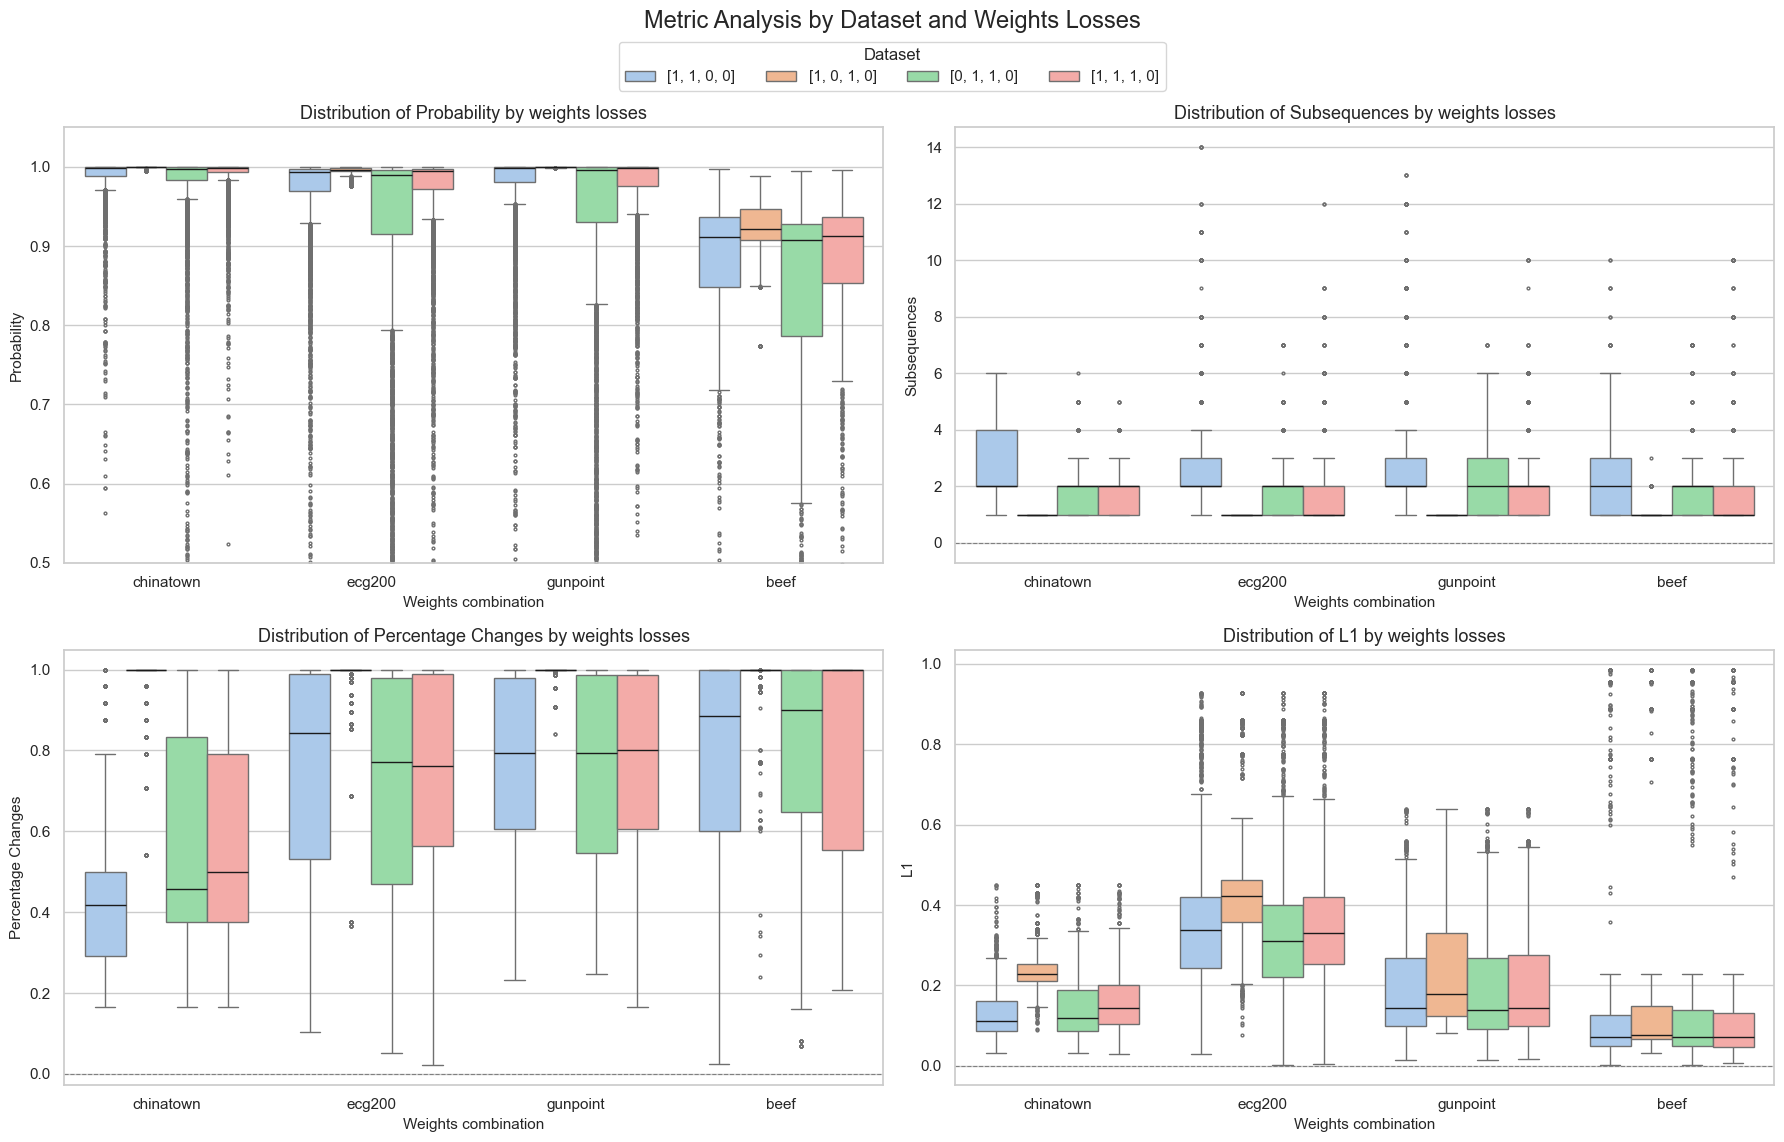

In [19]:
metrics = ["proba", "subsequences", "perc_changes", "L1_normalized"]
metric_titles = {
    "proba": "Probability",
    "subsequences": "Subsequences",
    "perc_changes": "Percentage Changes",
    "L1_normalized": "L1"
}

weight_orders = [
    "[1, 1, 0, 0]",
    "[1, 0, 1, 0]",
    "[0, 1, 1, 0]",
    "[1, 1, 1, 0]"
]
dataset_order = ["chinatown", "ecg200", "gunpoint", "beef"]

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    sns.boxplot(
        data=combined_df,
        x="dataset",
        y=metric,
        hue="weights_losses",
        order=dataset_order,
        hue_order=weight_orders,
        palette="pastel",
        ax=ax,
        fliersize=2,
        medianprops=dict(color="k", alpha=1)
    )
    ax.set_title(f"Distribution of {metric_titles[metric]} by weights losses", fontsize=13)
    ax.set_xlabel("Weights combination", fontsize=11)
    ax.set_ylabel(metric_titles[metric], fontsize=11)
    ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
    if metric == "proba":
        ax.set_ylim(bottom=0.5)
    elif metric == "L1":
        ax.set_ylim(top=125)
    if idx == 0:
        handles, labels = ax.get_legend_handles_labels()
    ax.legend_.remove()

fig.legend(
    handles,
    labels,
    title="Dataset",
    loc='upper center',
    bbox_to_anchor=(0.5, 0.98),
    ncol=len(dataset_order),
    fontsize=11,
    frameon=True
)

fig.suptitle(f"Metric Analysis by Dataset and Weights Losses", fontsize=17, y=1)
fig.tight_layout(rect=[0.0, 0.05, 1, 0.97])
plt.show()